In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
%store -r lexicondf

# Gaming activity from ATUS (2003-2020)

In [3]:
# activity summary dataset is in a wide format, one case per row
# (respondent attribute columns, one column for each activity 't<activity code>') column-wise
nonactivitycols = ['TUCASEID',
    'GEMETSTA',
    'GTMETSTA',
    'PEEDUCA',
    'PEHSPNON',
    'PTDTRACE',
    'TEAGE',
    'TELFS',
    'TEMJOT',
    'TESCHENR',
    'TESCHLVL',
    'TESEX',
    'TESPEMPNOT',
    'TRCHILDNUM',
    'TRDPFTPT',
    'TRERNWA',
    'TRHOLIDAY',
    'TRSPFTPT',
    'TRSPPRES',
    'TRYHHCHILD',
    'TUDIARYDAY',
    'TUFNWGTP',
    'TEHRUSLT',
    'TUYEAR',
    'TU20FWGT']
dsum = pd.read_csv("data/atussum-0320/atussum_0320.dat", usecols=nonactivitycols + ['t120307'])
tcols = dsum.columns[dsum.columns.str.startswith('t')]

In [4]:
# better column names
dsum = dsum.rename({
    'TUCASEID': 'caseid',
    'TEAGE':'age',
    'TELFS':'lfs',    # labor force status
    'TESCHENR':'student',
    'TESCHLVL':'studentWhere',
    'TESEX':'sex',
    'TUYEAR': 'year',
    'TRERNWA': 'weeklyEarnings',
    'TRHOLIDAY': 'holiday',
    'TEHRUSLT': 'workHouresPerWeek',
    'TUMONTH': 'month',
    'TUDIARYDAY':'dayofweek',
    'TRCHILDNUM': 'numChildren',
    'TUFNWGTP':'atusWeight',
    'TU20FWGT':'atusWeight2020'
}, axis=1)

# incorporate 2020 weights to the same atusWeight column
dsum.loc[dsum['atusWeight']==-1, 'atusWeight'] = dsum.loc[dsum['atusWeight']==-1, 'atusWeight2020']

# better values
dsum['student'] = dsum['student'] == 1
dsum['studentWhere'] = dsum['studentWhere'].replace([1,2], ['high school', 'College/Uni'])
dsum['weeklyEarnings'] /= 100.0    # adjust for two decimals
dsum['sex'] = dsum['sex'].replace([1,2], ['M', 'F'])
dsum['lfs'] = dsum['lfs'].replace(
    [1,2,3,4,5],
    ['Employed-at work', 'Employed-absent', 'Unemployed-on layoff', 'Unemployed-looking','Not in labor force'])

In [5]:
# get dates of the interviews from respondent file
resp = (
    pd.read_csv(
        "data/atusresp-0320/atusresp_0320.dat",
        usecols=['TUCASEID', 'TUDIARYDATE'])
    .rename({
        'TUCASEID': 'caseid',
        'TUDIARYDATE': 'date'}, axis=1)
)

dsum = dsum.merge(resp[['caseid', 'date']], on='caseid')
dsum['date'] = pd.to_datetime(dsum['date'], format='%Y%m%d')

We will only select the activity 'Playing games (120307)' to investigate people's gaming activity patterns as the survey has another category for 'Computer use for leisure (exc. Games) (120308)'.

In [6]:
gaming = dsum.copy().rename({
    't120307':'gaming_min'
}, axis=1)

In [7]:
def rotate_label(ax, axis='x', angle=45):
    methodname = f"get_{axis}ticklabels"
    for item in getattr(ax, methodname)():
        item.set_rotation(angle)

In [49]:
def clipped_weighted_average(x, weights, exclude_frac, exclude_zero=True):
    x, weights = x[x>0], weights[x>0]
    x, weights = x[x<np.quantile(x, 0.99)], weights[x<np.quantile(x, 0.99)]
    return np.average(x, weights=weights)

def weighted_quantile(x, weights, q=0.5, exclude_zero=True):
    if isinstance(x, pd.Series):
        x = x.values
    if isinstance(weights, pd.Series):
        weights = weights.values
    x, weights = x[x>0], weights[x>0]
    x, weights = x[x<np.quantile(x, 0.99)], weights[x<np.quantile(x, 0.99)]

    x, weights = x[x.argsort()], weights[x.argsort()]
    cumsum = weights.cumsum()
    return x[cumsum>=weights.sum()*q][0]

def weighted_std(values, weights):
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    return np.sqrt(variance)

## Yearly trend

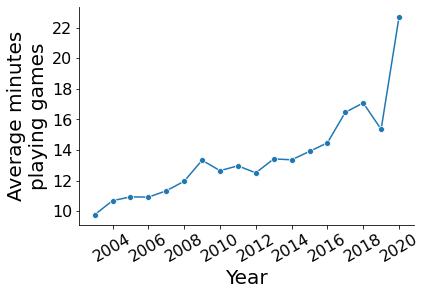

In [213]:
average_all = gaming.groupby('year').apply(lambda x: np.average(x['gaming_min'], weights=x['atusWeight'])).rename('average_min_all')
unweighted_average_all = gaming.groupby('year').apply(lambda x: np.average(x['gaming_min'])).rename('unweighted_average_all')
with plt.style.context("atus.mplstyle"):
    ax = sns.lineplot(x=average_all.index, y=average_all, marker='o')
#     sns.lineplot(x=unweighted_average_all.index, y=unweighted_average_all, marker='.', color='gray', ls='--')
    ax.set(xlabel='Year', ylabel='Average minutes\nplaying games', xticks=np.r_[2004:2021:2])
    rotate_label(ax, angle=30)

Average time over the entire population can increase because of two factors: more people are participating in the activity or people participating are spending more time on the activity. We can look at each factor by looking at participation rate and average hours spent by participants.

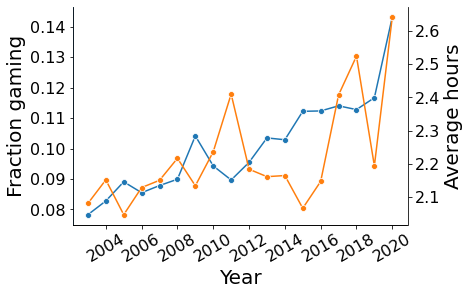

In [124]:
average_part_rate = gaming.groupby('year').apply(lambda x: np.average(x['gaming_min']>0, weights=x['atusWeight'])).rename('average_part_rate')
average_nonzero = gaming.groupby('year').apply(lambda x: np.average(x['gaming_min'], weights=x['atusWeight'] * (x['gaming_min']>0).astype(float))).rename('average_nonzero')

with plt.style.context("atus.mplstyle"):
    ax = sns.lineplot(x=average_part_rate.index, y=average_part_rate, marker='o')
    ax.set(xlabel='Year', ylabel='Fraction gaming', xticks=np.r_[2004:2021:2])
    ax2 = ax.twinx()
    ax2 = sns.lineplot(x=average_nonzero.index, y=average_nonzero/60., marker='o', color='C1')
    ax2.set(ylabel='Average hours')
    ax.spines['right'].set_visible(True)
    ax.spines['left'].set_color('C0')
    rotate_label(ax, angle=30)

The fraction of people playing games has been consistently increasing overall. By 2019, it has increased by 50% compared to 2003. But in 2020, it has particularly been boosted probably due to COVID19 as everyone needed to stay at home and gaming has emerged as an alternative to other outdoors socializing activities.

### Are people spending more time playing games?

The average hours trend above shows an increasing trend but with about 30 min year-to-year variations but this is complicated by a couple of factors:

1. Time resolution of an interview varies. Because these survey asks participants about yesterday, their response is from their memory. From the quantized time entries in the activity summary file, it can be presumed that often people would respond in units of 30 min but not less.
2. Because the distribution of gaming hours are long-tailed (i.e., there are some hardcore games), it is possible that these outliers drive the average particularly if they happen to be given a large weight.

In [172]:
gaming_nonzero = gaming.loc[gaming['gaming_min']>0].copy()
print('unweighted average = {:8.2f}'.format(
    np.average(gaming_nonzero['gaming_min'])))
print('weighted average   = {:8.2f}'.format(
    np.average(gaming_nonzero['gaming_min'], weights=gaming_nonzero['atusWeight'])))

unweighted average =   126.89
weighted average   =   134.40


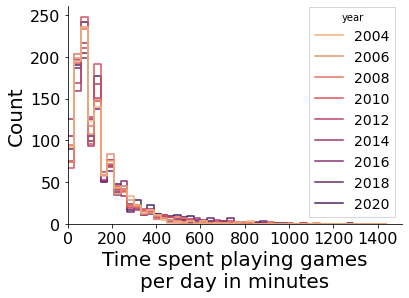

In [46]:
with plt.style.context("atus.mplstyle"):
    ax = sns.histplot(data=gaming.loc[(gaming['gaming_min']>0) & (gaming['year'].isin(np.r_[2004:2021:2]))],
                 hue='year', x='gaming_min',
                 palette='flare',
                 bins=np.linspace(0, 1440, 49),  # 30 min bins
                 element='step', fill=False,
                 alpha=0.5,)
    ax.set(xlim=(0,None), xlabel='Time spent playing games\nper day in minutes')

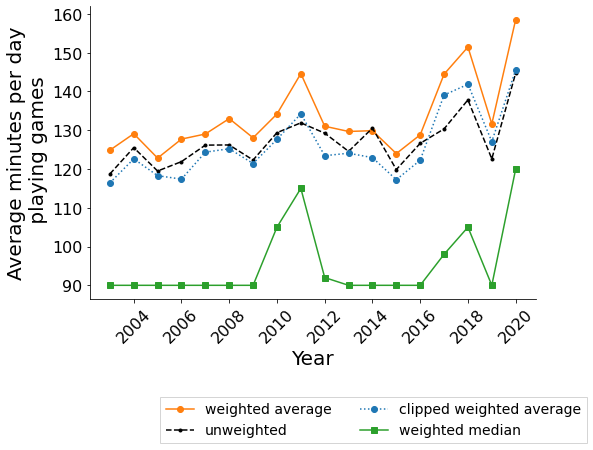

In [102]:
with plt.style.context("atus.mplstyle"):
    fig, ax = plt.subplots(gridspec_kw={'bottom':0.3},figsize=(8,7))
    gaming_min = (
        gaming.groupby('year')
            .apply(lambda x: np.average(x['gaming_min'][x['gaming_min']>0],
                                        weights=x['atusWeight'][x['gaming_min']>0]))
            .rename('gaming_min'))
    gaming_min_clipped = (
        gaming.groupby('year')
            .apply(lambda x: clipped_weighted_average(x['gaming_min'], x['atusWeight'], 0.05))
            .rename('gaming_min'))
    gaming_min_wm = (
        gaming.groupby('year')
            .apply(lambda x: weighted_quantile(x['gaming_min'], x['atusWeight'])))
    gaming_min_unweighted = (
        gaming.groupby('year')
            .apply(lambda x: np.average(x['gaming_min'][x['gaming_min']>0]))
            .rename('gaming_min'))
    ax.plot(gaming_min.index, gaming_min, marker='o',c='C1', label='weighted average')
    ax.plot(gaming_min_unweighted.index, gaming_min_unweighted, marker='.',c='k', ls='--', label='unweighted')
    ax.plot(gaming_min_clipped.index, gaming_min_clipped, marker='o',c='C0', ls=':', label='clipped weighted average')
    ax.plot(gaming_min_wm.index, gaming_min_wm, marker='s',c='C2', ls='-', label='weighted median')
    rotate_label(ax)
#     ax.legend(loc='upper left')
    ax.set(xticks=fraction_gaming.index[1::2],
           ylabel='Average minutes per day\n playing games', xlabel='Year',)
    plt.figlegend(loc='lower right', ncol=2)

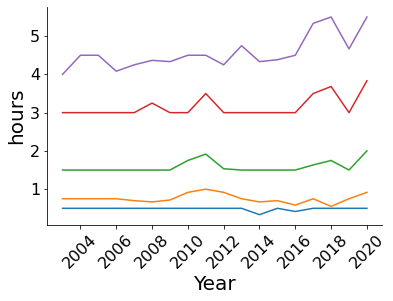

In [140]:
with plt.style.context("atus.mplstyle"):
    ax = plt.gca()
    for qval in [0.1, 0.2, 0.5, 0.8, 0.9]:
        q = gaming.groupby('year').apply(lambda x: weighted_quantile(x['gaming_min'], weights=x['atusWeight'] * (x['gaming_min']>0).astype(float), q=qval))
        sns.lineplot(x=q.index, y=q/60)
    ax.set(xlabel='Year', ylabel='hours', xticks=np.r_[2004:2021:2])
    rotate_label(ax)

## Age groups

We can break down this increasing trend by the age of the respondent to investigate which age group is most responsible for the trend. The age of the respondents start at 15, and goes up to 85.

In [144]:
age_bins = [13,18,25,35,45,65,100]
groupbins = ['year', pd.cut(gaming['age'], age_bins)]
gaming_year_age = pd.DataFrame({
    'gaming_min': (
        gaming.groupby(groupbins)
            .apply(lambda x: np.average(x['gaming_min'], weights=x['atusWeight']))
            .rename('gaming_min')),
    'fraction': (
        gaming.groupby(groupbins)
            .apply(lambda x: np.average(x['gaming_min']>0, weights=x['atusWeight']))),
    'fraction_nonweighted': (
        gaming.groupby(groupbins)
            .apply(lambda x: np.average(x['gaming_min']>0))),
    'gaming_min_nonzero': (
        gaming.groupby(groupbins)
            .apply(lambda x: np.average(x['gaming_min'], weights=x['atusWeight'] * (x['gaming_min']>0).astype(float)))),
}).reset_index()

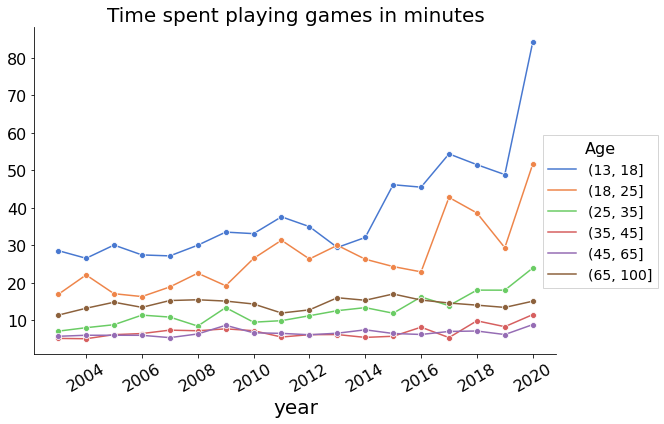

In [146]:
with plt.style.context("atus.mplstyle"):
    sns.set_palette("muted")
    fig, ax = plt.subplots(gridspec_kw={'right':0.85},figsize=(10,6))

    ax = sns.lineplot(
        data=gaming_year_age,
        x='year', y='gaming_min', hue='age', marker='o')
#     sns.lineplot(
#         data=gaming_year_age,
#         x='year', y='gaming_min_unweighted', hue='age', ls=':')
    rotate_label(ax, angle=30)
    ax.legend_.set_visible(False)
    ax.set(ylabel='')
    ax.set_xticks(np.r_[2004:2021:2])
    ax.set_title("Time spent playing games in minutes", fontsize=20)
    plt.figlegend(title='Age', title_fontsize=16, loc='center right')

While average time spent on playing games over all population increased for all age groups, teenagers and young adults particularly responsible for more-than-normal increase.

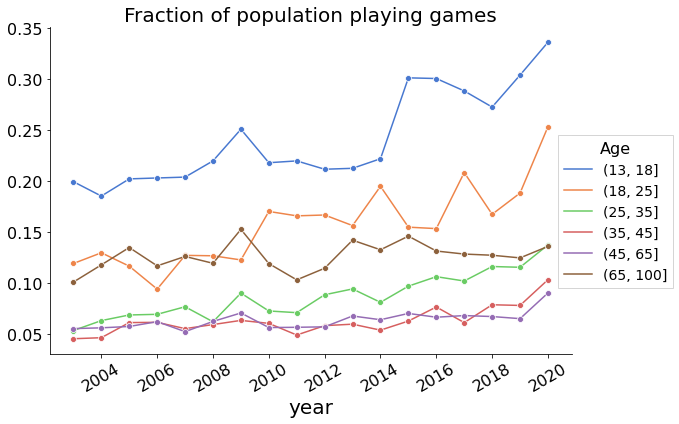

In [145]:
with plt.style.context("atus.mplstyle"):
    sns.set_palette("muted")
    fig, ax = plt.subplots(gridspec_kw={'right':0.85},figsize=(10,6))

    ax = sns.lineplot(
        data=gaming_year_age,
        x='year', y='fraction', hue='age', marker='o')
#     sns.lineplot(
#         data=gaming_year_age,
#         x='year', y='fraction_nonweighted', hue='age', ax=ax, ls=':')

    rotate_label(ax, angle=30)
    ax.legend_.set_visible(False)
    ax.set(ylabel='')
    ax.set_xticks(np.r_[2004:2021:2])
    ax.set_title("Fraction of population playing games", fontsize=20)
    plt.figlegend(title='Age', title_fontsize=16, loc='center right')

Participation rate on gaming activity also increased for all age groups. It is noticeable that the older age groups (35-45, 45-65), which did not show much change in participation rate also increased quite significantly.

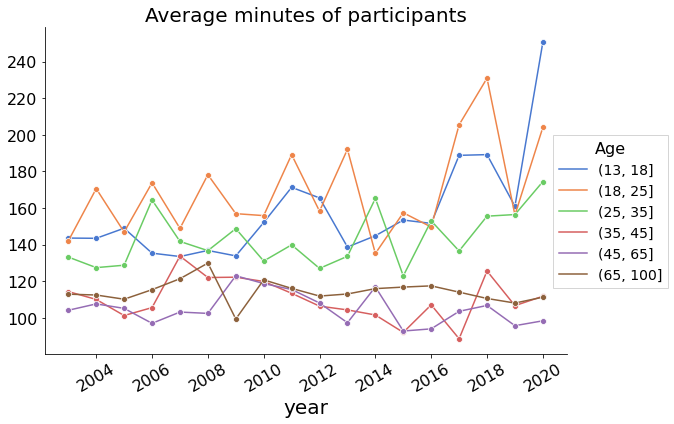

In [207]:
with plt.style.context("atus.mplstyle"):
    sns.set_palette("muted")
    fig, ax = plt.subplots(gridspec_kw={'right':0.85},figsize=(10,6))

    ax = sns.lineplot(
        data=gaming_year_age,
        x='year', y='gaming_min_nonzero', hue='age', marker='o')
#     sns.lineplot(
#         data=gaming_year_age,
#         x='year', y='fraction_nonweighted', hue='age', ax=ax, ls=':')

    rotate_label(ax, angle=30)
    ax.legend_.set_visible(False)
    ax.set(ylabel='')
    ax.set_xticks(np.r_[2004:2021:2])
    ax.set_title("Average minutes of participants", fontsize=20)
    plt.figlegend(title='Age', title_fontsize=16, loc='center right')

Average time for participatns are noisy due to the issues mentioned earlier but shows increse for people younger than 35.

The two factors combined (more people gaming and on average longer) result in a huge increase in the average minutes spent gaming in 2020. Regardless of the boost in 2020, people have been spending more time gaming: by 2018, the average time has doubled compared to 15 years ago.

## When do people play games?

In [185]:
gaming['dayofyear'] = gaming['date'].dt.day_of_year
gaming['day'] = gaming['date'].dt.day
gaming['month'] = gaming['date'].dt.month

In [186]:
gaming['holiday'].value_counts()

0    215827
1      3541
Name: holiday, dtype: int64

In [187]:
gaming.groupby('holiday').apply(lambda x: np.average(x['gaming_min'], weights=x['atusWeight']))

holiday
0    13.487062
1    19.825423
dtype: float64

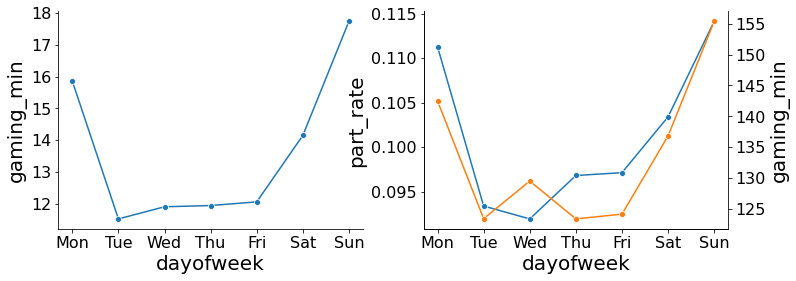

In [209]:
with plt.style.context("atus.mplstyle"):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
    sns.lineplot(
        data=(gaming.groupby('dayofweek').apply(lambda x: np.average(x['gaming_min'], weights=x['atusWeight']))
              .rename('gaming_min')
              .reset_index()),
        x='dayofweek', y='gaming_min', marker='o', ax=ax1)
    ax1.set_xticks([1,2,3,4,5,6,7])
    ax1.set_xticklabels(['Mon','Tue','Wed','Thu','Fri','Sat', 'Sun'])

    ax2 = sns.lineplot(
        data=(gaming.groupby('dayofweek').apply(lambda x: np.average(x['gaming_min']>0, weights=x['atusWeight']))
              .rename('part_rate')
              .reset_index()),
        x='dayofweek', y='part_rate', marker='o', ax=ax2)
    ax2a = ax2.twinx()
    ax2.spines['right'].set_visible(True)
    sns.lineplot(
        data=(gaming.groupby('dayofweek').apply(lambda x: np.average(x['gaming_min'], weights=x['atusWeight'] * (x['gaming_min']>0).astype(float)))
              .rename('gaming_min')
              .reset_index()),
        x='dayofweek', y='gaming_min', marker='o', color='C1', ax=ax2a)
    ax2.set_xticks([1,2,3,4,5,6,7])
    ax2.set_xticklabels(['Mon','Tue','Wed','Thu','Fri','Sat', 'Sun'])

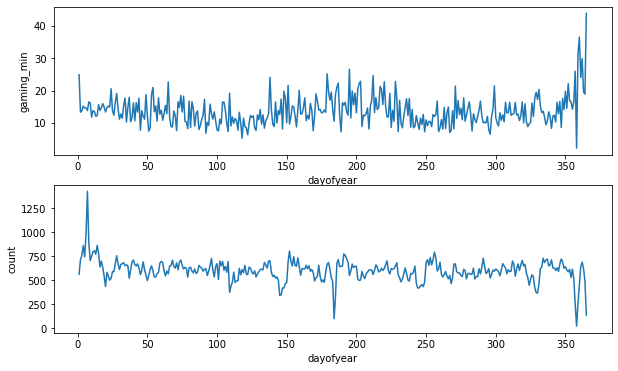

In [210]:
groupbins=['dayofyear']
gaming_week = pd.DataFrame({
    'gaming_min': (
        gaming.groupby(groupbins)
            .apply(lambda x: np.average(x['gaming_min'], weights=x['atusWeight']))
#             .apply(lambda x: np.mean(x['gaming_min'][x['gaming_min']>0]))
            .rename('gaming_min')),
    'count': (
        gaming.groupby(groupbins)['gaming_min'].count())
}).reset_index()

fig, (ax1,ax2) = plt.subplots(2,1, figsize=(10,6))
sns.lineplot(
    data=gaming_week,
    x='dayofyear', y='gaming_min', ax=ax1)
sns.lineplot(
    data=gaming_week,
    x='dayofyear', y='count', ax=ax2);

Given the weekly trend, it makes sense to look at week trend by week number rather than day.

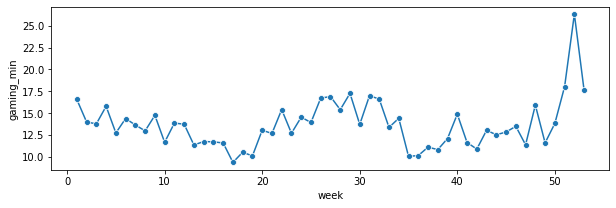

In [201]:
groupbins=[gaming['date'].dt.isocalendar().week]
gaming_week = pd.DataFrame({
    'gaming_min': (
        gaming.groupby(groupbins)
            .apply(lambda x: np.average(x['gaming_min'], weights=x['atusWeight']))
#             .apply(lambda x: np.mean(x['gaming_min'][x['gaming_min']>0]))
            .rename('gaming_min')),
    'count': (
        gaming.groupby(groupbins)['gaming_min'].count())
}).reset_index()

plt.figure(figsize=(10,3))
sns.lineplot(
    data=gaming_week,
    x='week', y='gaming_min', marker='o');

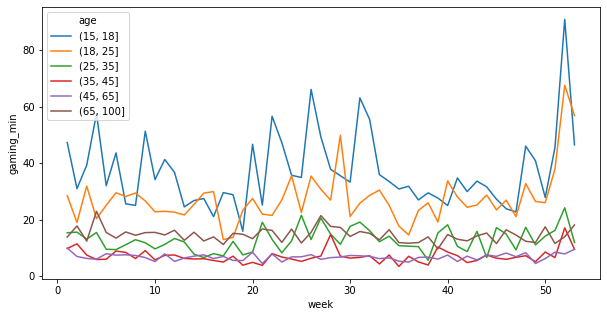

In [203]:
age_bins = [15,18,25,35,45,65,100]
groupbins = [pd.cut(gaming['age'], age_bins), gaming['date'].dt.isocalendar().week]


gaming_age_week = pd.DataFrame({
    'gaming_min': (
        gaming.groupby(groupbins)
            .apply(lambda x: np.average(x['gaming_min'], weights=x['atusWeight']))
#             .apply(lambda x: np.mean(x['gaming_min'][x['gaming_min']>0]))
            .rename('gaming_min')),
    'count': (
        gaming.groupby(groupbins)['gaming_min'].count())
}).reset_index()

plt.figure(figsize=(10,5))
sns.lineplot(
    data=gaming_age_week,
    x='week', y='gaming_min', hue='age');

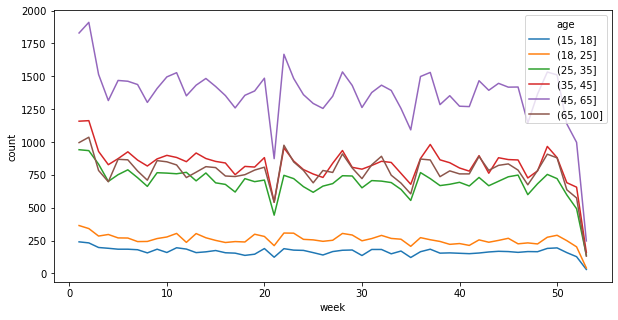

In [206]:
plt.figure(figsize=(10,5))
sns.lineplot(
    data=gaming_age_week,
    x='week', y='count', hue='age');